In [1]:
import pandas as pd
import numpy as np

In [2]:
test_dataset = pd.read_csv('test_table.csv')
user_dataset = pd.read_csv('user_table.csv')

In [3]:
test_dataset.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [4]:
test_dataset.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


In [5]:
len(test_dataset)

453321

In [6]:
user_dataset.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [7]:
user_dataset.describe()

,user_id,age
count,452867.000000,452867.000000
mean,499944.805166,27.130740
std,288676.264784,6.776678
min,1.000000,18.000000
25%,249819.000000,22.000000
50%,500019.000000,26.000000
75%,749543.000000,31.000000
max,1000000.000000,70.000000


In [8]:
len(user_dataset)

452867

Look for any null or empty values

In [9]:
user_dataset.apply(lambda x: sum(x.isnull()),axis=0) 

user_id    0
sex        0
age        0
country    0
dtype: int64

In [10]:
test_dataset.apply(lambda x: sum(x.isnull()),axis=0)

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
dtype: int64

Ads channel seems to be missing lot of data points.

Let's first combine the 2 tables to one.

In [12]:
data = pd.merge(test_dataset, user_dataset, how='inner', on='user_id',sort=True)
dataset = data
dataset.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,1,2015-12-02,SEO,Web,EN,NaN,Chrome,0,0,M,38,Chile
1,2,2015-11-30,SEO,Mobile,ES,NaN,Android_App,0,0,M,27,Colombia
2,3,2015-12-03,SEO,Mobile,ES,NaN,Iphone_App,0,1,M,18,Guatemala
3,5,2015-11-30,Ads,Web,ES,Facebook,Chrome,0,1,M,22,Argentina
4,8,2015-12-03,Ads,Mobile,ES,Google,Android_App,0,1,M,19,Venezuela


In [13]:
dataset.describe()

,user_id,conversion,test,age
count,452867.000000,452867.000000,452867.000000,452867.000000
mean,499944.805166,0.049560,0.476462,27.130740
std,288676.264784,0.217034,0.499446,6.776678
min,1.000000,0.000000,0.000000,18.000000
25%,249819.000000,0.000000,0.000000,22.000000
50%,500019.000000,0.000000,0.000000,26.000000
75%,749543.000000,0.000000,1.000000,31.000000
max,1000000.000000,1.000000,1.000000,70.000000


Let's take a look at the distribution using plots.

### By countries

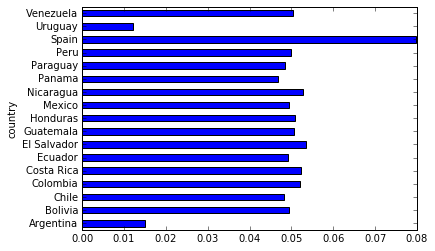

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
country_counts = dataset[dataset['test'] == 0].groupby('country')['conversion']
country_counts = country_counts.sum()/country_counts.count()
country_counts.plot(kind='barh')

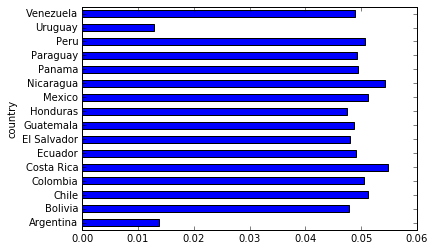

In [15]:
country_counts = dataset[dataset['test'] == 1].groupby('country')['conversion']
country_counts = country_counts.sum()/country_counts.count()
country_counts.plot(kind='barh')

Both the control and test group have almost equal conversion rates, with the control group performing little better. So, in fact the test is showing negative result.

## Hypothesis-test

We have to prove that there is no difference between the test and control group and the difference is due to chance. So our null hypothesis is that, there is no difference between the conversion rates of test and control group. Remove spain as it is not present in both the groups

In [16]:
conversion_rate1 = dataset[(dataset['test'] == 0) & (dataset['country'] != 'Spain')]['conversion']
conversion_rate1.mean()

0.04829179055749524

In [17]:
conversion_rate2 = dataset[(dataset['test'] == 1) & (dataset['country'] != 'Spain')]['conversion']
conversion_rate2.mean()

0.043411161678422794

The conversion rate for test group is actually lower.

In [18]:
data1 = dataset[dataset['country'] != 'Spain']

In [19]:
from scipy.stats import chi2_contingency

freq = pd.crosstab(data1['test'], data1['conversion'])
chi2,pval,dof,expected = chi2_contingency(freq)

In [20]:
freq

conversion,0,1
test,,
0,176362,8949
1,206407,9367


In [21]:
pval

1.653553456785947e-13

In [22]:
chi2

54.37858181419832

P-value for chi2 statistic is very small. Reject null, the difference is real.

What could be happening?
* The conversion rate is lower for translated version. It could mean that the local translations are worse.

# Classification

To determine the future and predict if same thing will happen, lets predict the conversion behavior from the features to determine what affects this outcome. For this, remove Spain as it is the most prominent feature for control group.

In [23]:
len(dataset[dataset['test'] == 0])
d1 = data[(data['country'] != 'Spain')]

The dataset is balanced

The code below creates a number correponding to various values for the source, device, browser_language,sex, country, ads_channel and browser variables.

In [24]:

from sklearn.cross_validation import train_test_split

d1['n_source'] = pd.factorize(d1['source'])[0]
d1['n_country'] = pd.factorize(d1['country'])[0]
d1['n_device'] = pd.factorize(d1['device'])[0]
d1['n_lang'] = pd.factorize(d1['browser_language'])[0]
d1['n_sex'] = pd.factorize(d1['sex'])[0]
d1['n_ads'] = pd.factorize(d1['ads_channel'])[0]
d1['n_browser'] = pd.factorize(d1['browser'])[0]

/Users/NiaVivek/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/NiaVivek/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/NiaVivek/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [25]:
d = d1

In [26]:
d.columns

Index(['user_id', 'date', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'conversion', 'test', 'sex', 'age', 'country',
       'n_source', 'n_country', 'n_device', 'n_lang', 'n_sex', 'n_ads',
       'n_browser'],
      dtype='object')

In [34]:
from sklearn.utils import shuffle
import math
from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

#clf = LogisticRegression()
classifiers=[#("log_model",LogisticRegression()),
            #("svm", svm.SVC()),
            #("SGDC", SGDClassifier()),
            ("RF",RandomForestClassifier())]

accuracy = 0
accuracy_dev = 0
best_model = None
prediction = None
y = None
best_modelname = None

for name,clf in classifiers:
    
    predictors = ['age',
       'n_source', 'n_country', 'n_device', 'n_lang', 'n_sex', 'n_ads',
       'n_browser']
    outcome = 'conversion'
    X = d[predictors]
    Y = d[outcome]
    X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=20)


    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


    clf_model = clf.fit(X_train, y_train)
    # Predict on test

    predicted1 = clf_model.predict(X_test)
    test_accuracy = accuracy_score(y_test,predicted1)
    print(test_accuracy)

    # Save models and accuracy so that we can use it later
    if (test_accuracy > accuracy):
        accuracy = test_accuracy

        best_model = clf_model
        best_modelname = clf
        prediction = predicted1
        y = y_test


0.951070222023


There could be overfitting of data, so best to do cross validation.

## Cross validation

In [37]:
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
import numpy as np

#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
    #Fit the model:
    model.fit(data[predictors],data[outcome])

    #Make predictions on training set:
    predictions = model.predict(data[predictors])

    #Print accuracy
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print("Accuracy : %s" % "{0:.3%}".format(accuracy))

    #Perform k-fold cross-validation with 5 folds
    kf = KFold(data.shape[0], n_folds=5)
    error = []
    for train, test in kf:
        # Filter training data
        train_predictors = (data[predictors].iloc[train,:])

        # The target we're using to train the algorithm.
        train_target = data[outcome].iloc[train]

        # Training the algorithm using the predictors and target.
        model.fit(train_predictors, train_target)

        #Record error from each cross-validation run
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))

        print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

    #Fit the model again so that it can be refered outside the function:
    model.fit(data[predictors],data[outcome]) 

In [38]:
outcome_var = 'conversion'
predictor_var = predictors

classification_model(clf, d,predictor_var,outcome_var)

Accuracy : 95.618%
Cross-Validation Score : 95.055%
Cross-Validation Score : 95.074%
Cross-Validation Score : 95.108%
Cross-Validation Score : 95.089%
Cross-Validation Score : 95.073%


Not much overfitting.

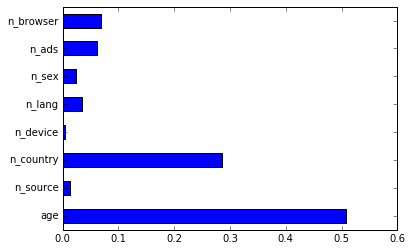

In [39]:
#predictors_name = np.array(predictors)
model = RandomForestClassifier()
model.fit(d[predictors], d['conversion'])
feature_importances = model.feature_importances_
importance = pd.Series(feature_importances, index = predictors)
plt.figure()
importance.plot(kind = 'barh')

AFter removing Spain, age seems to be more prominent feature influencing this trend - using only top 5 features.

In [42]:

predictors = ['age',
   'n_country','n_lang', 'n_sex', 'n_ads',
   'n_browser']
outcome = 'conversion'
X = d[predictors]
Y = d[outcome]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=20)


scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


clf_model = model.fit(X_train, y_train)
# Predict on test

predicted1 = clf_model.predict(X_test)
test_accuracy = accuracy_score(y_test,predicted1)
print(test_accuracy)


0.951294613361
